In [ ]:
import numpy as np
import torch
from torch import nn
from torch.optim import Adam
from tqdm import tqdm
import matplotlib.pyplot as plt
from model import MambaFull, generate_data

# Define model parameters and hyperparameters
class DotDict(dict):
    def __init__(self, **kwds):
        self.update(kwds)
        self.__dict__ = self

args=DotDict()
args.bsz=100
args.d_model = 64
args.coord_dim = 2
args.nb_layers = 2
args.mlp_cls = nn.Identity #nn.Linear
args.city_count = 50

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 2. 0. 3. 5. 0. 0. 0. 0. 1. 4. 6. 6. 6. 6.
 6.] [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 2. 3. 5. 1.
 4.]


In [71]:
seed = 402
torch.manual_seed(seed)
np.random.seed(seed)

model = MambaFull(args.d_model, args.city_count, args.nb_layers, args.coord_dim, args.mlp_cls)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

  0%|          | 0/50001 [00:00<?, ?it/s]

Epoch 0: loss=1.975183129310608


 10%|█         | 5016/50001 [00:39<05:26, 137.75it/s]

Epoch 5000: loss=1.2243884801864624


 20%|██        | 10025/50001 [01:13<04:43, 140.93it/s]

Epoch 10000: loss=1.1828720569610596


 30%|███       | 15018/50001 [01:48<04:16, 136.48it/s]

Epoch 15000: loss=1.1681764125823975


 40%|████      | 20022/50001 [02:25<03:37, 137.97it/s]

Epoch 20000: loss=1.1661758422851562


 50%|█████     | 25019/50001 [03:01<02:58, 139.65it/s]

Epoch 25000: loss=1.1658191680908203


 60%|██████    | 30022/50001 [03:36<02:15, 147.81it/s]

Epoch 30000: loss=1.1654599905014038


 70%|███████   | 35028/50001 [04:11<01:47, 139.46it/s]

Epoch 35000: loss=1.1654242277145386


 80%|████████  | 40025/50001 [04:46<01:10, 140.98it/s]

Epoch 40000: loss=1.1655418872833252


 90%|█████████ | 45019/50001 [05:22<00:35, 142.27it/s]

Epoch 45000: loss=1.165798544883728


100%|██████████| 50001/50001 [05:57<00:00, 139.79it/s]


Epoch 50000: loss=1.1654220819473267


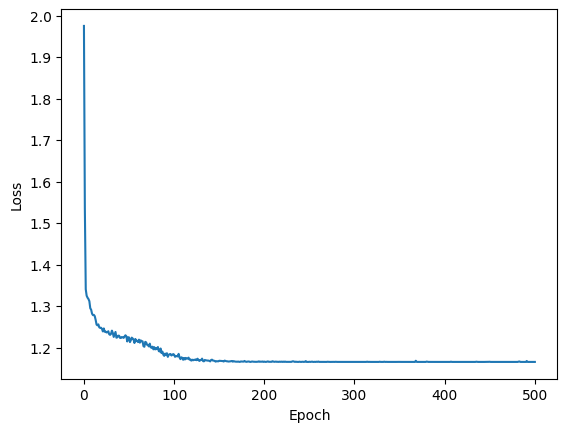

In [72]:
# Define a loss function
loss_fn = nn.CrossEntropyLoss()

# Define an optimizer
optimizer = Adam(model.parameters(), lr=1e-4)

# List to store loss values
loss_values = []
best_loss = float('inf')

# For each epoch
for epoch in tqdm(range(1)):
    # Generate data
    inputs = generate_data(device, args.bsz, args.seqlen, args.city_count, args.coord_dim)
    outputs = model(inputs)
    print(outputs.shape)

    outputs = nn.Softmax(dim=2)(outputs)
    
    '''loss = loss_fn(outputs.reshape(-1,7), targets.reshape(-1))

    # Backward pass: compute the gradients of the loss with respect to the model's parameters
    loss.backward()

    # Update the model's parameters
    optimizer.step()

    # Zero the gradients
    optimizer.zero_grad()

    # Save checkpoint every 10,000 epochs
    if loss.item() < best_loss:
        best_loss = loss.item()
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss.item()
        }
        torch.save(checkpoint, 'best_checkpoint.pt')'''
    
# Plot loss values
'''plt.plot(loss_values)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()'''

In [75]:
checkpoint = torch.load('mamba/best_checkpoint.pt')
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

MambaFull(
  (embedding): Embedding(7, 64)
  (layers): ModuleList(
    (0-1): 2 x ResidualBlock(
      (mixer): Mamba(
        (in_proj): Linear(in_features=64, out_features=256, bias=False)
        (conv1d): Conv1d(128, 128, kernel_size=(4,), stride=(1,), padding=(3,), groups=128)
        (act): SiLU()
        (x_proj): Linear(in_features=128, out_features=36, bias=False)
        (dt_proj): Linear(in_features=4, out_features=128, bias=True)
        (out_proj): Linear(in_features=128, out_features=64, bias=False)
      )
      (norm): RMSNorm()
    )
  )
  (final_norm): RMSNorm()
  (output_head): Linear(in_features=64, out_features=7, bias=False)
)

In [76]:
print(sum(p.numel() for p in model.parameters()))
inputs, targets = generate_data(batch_size=10000)
inputs = torch.from_numpy(inputs).long().to(device)
targets = torch.from_numpy(targets).long().to(device)
outputs = model(inputs)
outputs = nn.Softmax(dim=2)(outputs)
print(inputs[0])
print(outputs[0].argmax(dim=1))
print('accuracy:', (outputs.argmax(dim=2) == targets).float().mean())
print(targets[0])

66368
tensor([0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 2, 0, 3, 0, 5, 0, 0, 0, 1, 6, 6, 6, 6,
        6], device='cuda:0')
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 2, 3, 5,
        1], device='cuda:0')
accuracy: tensor(1.0000, device='cuda:0')
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 2, 3, 5,
        1], device='cuda:0')
